# 02.10.11 - SVM MFCC20 (sampled per hive)


## Goals

In this experiment we intend to assess SVM classifier performance when picking for training a fixed number of samples per hive.

We demonstrate that on the reference dataset, fair (from an operational standpoint) F-measure can consistently be achieved by training on as little as only 12 samples per hive (training set = 72 samples = 0,3% of the dataset)



## Prerequisites

- The dataset exists (if not, execute 02.00)
- The dataset features have been populated (if not, execute 02.01)

<hr style="border:1px solid gray"></hr>

### Step 1: Get previously created dataset

In [1]:
import warnings                      # This block prevents display of harmless warnings, but should be
warnings.filterwarnings('ignore')    # commented out till the experiment final version,
                                     # in order to avoid missing "real" warnings 

import kilroy_was_here               # Mandatory. Allow access to shared python code from repository root

from audace.jupytools import (       # AuDACE imports
    iprint,                          # timestamped (to the ms) print with CPU and RAM consumption information
    predestination,                  # Seeds the various PRNGs for reproducibility
    say_my_name                      # dynamically gets notebook name
)

from audace.audiodataset import AudioDataset      # Main class for audio dataset handling


#########################
# Experiment parameters #
#########################

EXP_NAME = say_my_name()  # Experiment name will be used to create outputs directory

DATASET_NAME = 'MAIN1000' # Dataset name is the master key for dataset addressing
                          # Change it according to the dataset you want to process

FEATURE_NAME = 'mfcc20'   # Name of the feature used for classification
LABEL_NAME = 'queen'      # Name of the label used for classification
KEY_NAME = 'hive'         # Name of the label used as axis for dataset splitting

TRAINING_SIZE = 12        # size to select for training, for each key value
                          # if int: number of samples per key value
                          # if float: ratio of samples per key value

REPEAT = 500              # Number of runs for performances statistics

KERNEL = 'rbf'            # svm kernel
C = 1                     # svm penalty factor
GAMMA = 'scale'           # rbf kernel gamma factor


# Initialize Dataset Object. 
ds = AudioDataset(DATASET_NAME)
    
# Display AudioDataset summary    
ds.info()

# Build dataframe containing all the information needed to conduct the experiment
sql = F"SELECT {FEATURE_NAME}, {LABEL_NAME}, {KEY_NAME} FROM samples WHERE nobee = 0"
df = ds.queryDataFrame(sql)

[2020-09-05/13:04:20.400|17.5%|68.8%|0.28GB] ------------------------------------------------------
[2020-09-05/13:04:20.400|00.0%|68.8%|0.28GB] DATASET NAME          : MAIN1000
[2020-09-05/13:04:20.401|00.0%|68.8%|0.28GB] DATASET PATH          : D:\Jupyter\ShowBees\datasets\MAIN1000
[2020-09-05/13:04:20.401|00.0%|68.8%|0.28GB] DATASET DB PATH       : D:\Jupyter\ShowBees\datasets\MAIN1000\MAIN1000.db
[2020-09-05/13:04:20.402|37.5%|68.8%|0.28GB] DATASET SAMPLES PATH  : D:\Jupyter\ShowBees\datasets\MAIN1000\samples
[2020-09-05/13:04:20.403|00.0%|68.8%|0.28GB] NB SOURCE AUDIO FILES : 48
[2020-09-05/13:04:20.404|00.0%|68.8%|0.28GB] SAMPLE RATE           : 22050
[2020-09-05/13:04:20.404|00.0%|68.8%|0.28GB] DURATION              : 1.0
[2020-09-05/13:04:20.404|00.0%|68.8%|0.28GB] OVERLAP               : 0.0
[2020-09-05/13:04:20.404|00.0%|68.8%|0.28GB] NB AUDIO CHUNKS       : 24788
[2020-09-05/13:04:20.404|00.0%|68.8%|0.28GB] ------------------------------------------------------


<hr style="border:1px solid gray"></hr>

### Step 2: Process SVM learning and display performance indicators for one run

In [2]:
import numpy as np
from sklearn import svm, metrics
from sklearn.preprocessing import StandardScaler
from audace.splitters import splitTrainTestStratified

# Seed the various PRNGs
predestination()

# Build training and test datasets
iprint(">>>>> Building partitions training/test")
X_train, X_test, y_train, y_test = splitTrainTestStratified(
    df,
    TRAINING_SIZE,
    FEATURE_NAME,
    LABEL_NAME,
    KEY_NAME
)

# Standardize data 
iprint(">>>>> Standardize")
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Create a SVM Classifier, using the experiment parameters
clf = svm.SVC(kernel=KERNEL, C=C, gamma=GAMMA)

#Train the model using the training sets
iprint('>>>>> Train')
clf.fit(X_train, y_train)

#Predict the response for test dataset
iprint('>>>>> Predict')
y_pred = clf.predict(X_test)

# Display information about the classifier performance
iprint(F"Trained over {len(y_train)} / Tested over {len(y_test)}")
iprint("Accuracy  :",metrics.accuracy_score(y_test, y_pred))
iprint("Precision :",metrics.precision_score(y_test, y_pred))
iprint("Recall    :",metrics.recall_score(y_test, y_pred))
iprint("F-Measure :",metrics.f1_score(y_test, y_pred))


[2020-09-05/13:04:20.749|14.2%|70.8%|0.35GB] >>>>> Building partitions training/test
[2020-09-05/13:04:20.853|13.0%|71.5%|0.41GB] >>>>> Standardize
[2020-09-05/13:04:20.964|24.1%|71.6%|0.41GB] >>>>> Train
[2020-09-05/13:04:20.972|75.0%|71.6%|0.41GB] >>>>> Predict
[2020-09-05/13:04:22.112|13.7%|70.7%|0.41GB] Trained over 72 / Tested over 17133
[2020-09-05/13:04:22.114|00.0%|70.7%|0.41GB] Accuracy  : 0.9234226346816086
[2020-09-05/13:04:22.121|50.0%|70.7%|0.41GB] Precision : 0.9861859372841553
[2020-09-05/13:04:22.127|00.0%|70.7%|0.41GB] Recall    : 0.8548676805173033
[2020-09-05/13:04:22.133|00.0%|70.7%|0.41GB] F-Measure : 0.9158434894162925


<hr style="border:1px solid gray"></hr>

### Step 3: Display performance report for one run

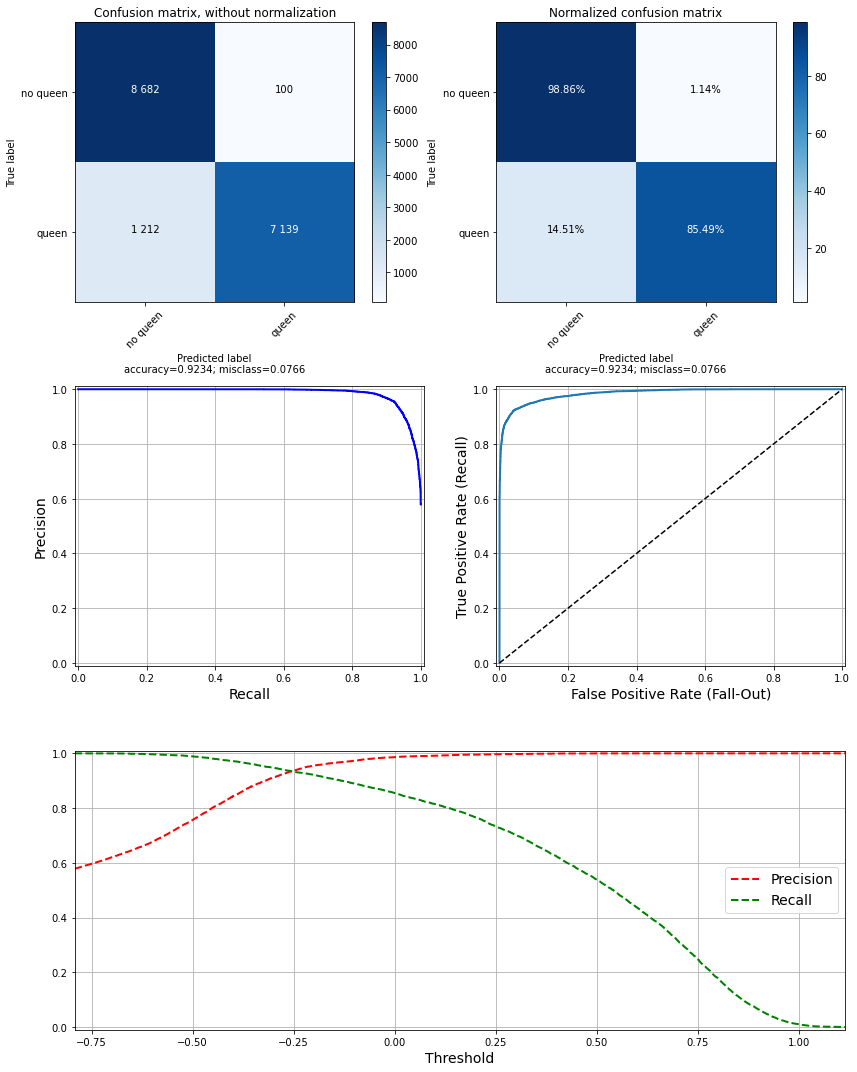

------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

    no queen       0.88      0.99      0.93      8782
       queen       0.99      0.85      0.92      8351

    accuracy                           0.92     17133
   macro avg       0.93      0.92      0.92     17133
weighted avg       0.93      0.92      0.92     17133

------------------------------------------------------------------------------------------
Area Under ROC Curve 0.9843140331156569
------------------------------------------------------------------------------------------


In [3]:
from audace.plotters import clf_full_report
from sklearn import metrics

target_names = ['no queen', 'queen']

# Build figure name based on parameters
figure_name = F"Full Report {KERNEL} - ({DATASET_NAME}) - Trn{TRAINING_SIZE} - C{C}"
if KERNEL != 'linear':
    figure_name += F" - G{GAMMA}"

# Display full report and save figures
clf_full_report(clf, X_test, y_test, target_names, EXP_NAME, figure_name)


print("------------------------------------------------------------------------------------------")
print(metrics.classification_report(y_test, y_pred , target_names=target_names))
print("------------------------------------------------------------------------------------------")
print('Area Under ROC Curve', metrics.roc_auc_score(y_test, clf.decision_function(X_test)))
print("------------------------------------------------------------------------------------------")

<hr style="border:1px solid gray"></hr>

### Step 4: Compute F-Measure distribution over several runs

In [4]:
from tqdm import tqdm

def perform_one_run(df, kernel, C, gamma):
    # Build training and test datasets
    X_train, X_test, y_train, y_test = splitTrainTestStratified(
        df,
        TRAINING_SIZE,
        FEATURE_NAME,
        LABEL_NAME,
        KEY_NAME
    )

    # Standardize data 
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    #Create a SVM Classifier, using the experiment parameters
    clf = svm.SVC(kernel=kernel, C=C, gamma=gamma)

    #Train the model using the training sets
    clf.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    return metrics.f1_score(y_test, y_pred)
    
# Seed the various PRNGs
predestination()

#Create a SVM Classifier, using the experiment parameters
clf = svm.SVC(kernel=KERNEL, C=C, gamma=GAMMA)

# Collect performance measure over several runs
fmeasures = np.empty(REPEAT)
for i in tqdm(range(REPEAT)):
    #iprint(F"============== RUN {i} ==============")
    fmeasures[i] = perform_one_run(df, KERNEL, C, GAMMA)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [12:51<00:00,  1.54s/it]


<hr style="border:1px solid gray"></hr>

### Step 5: Display F-Measure distribution statistics and histogram

Mean   : 0.8756165616989493
Median : 0.8845422197606354
std    : 0.04588012129400726
var    : 0.0021049855299528184
Min    : 0.7167885106198902
Max    : 0.9447124304267162


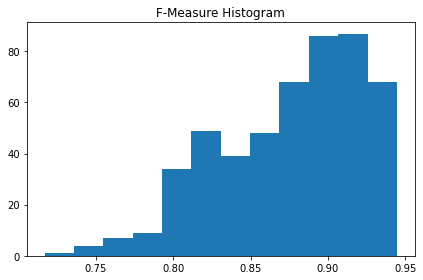

In [5]:
import matplotlib.pyplot as plt
from audace.plotters import save_fig

print("Mean   :", fmeasures.mean())
print("Median :", np.median(fmeasures))
print("std    :", fmeasures.std())
print("var    :", fmeasures.var())
print("Min    :", fmeasures.min())
print("Max    :", fmeasures.max())

_ = plt.hist(fmeasures, bins='auto')
plt.title("F-Measure Histogram")

figure_name = "F-Measure Histogram " + F" - ({DATASET_NAME}) - C{C} - G{GAMMA} -R{REPEAT}"

save_fig(EXP_NAME, figure_name)